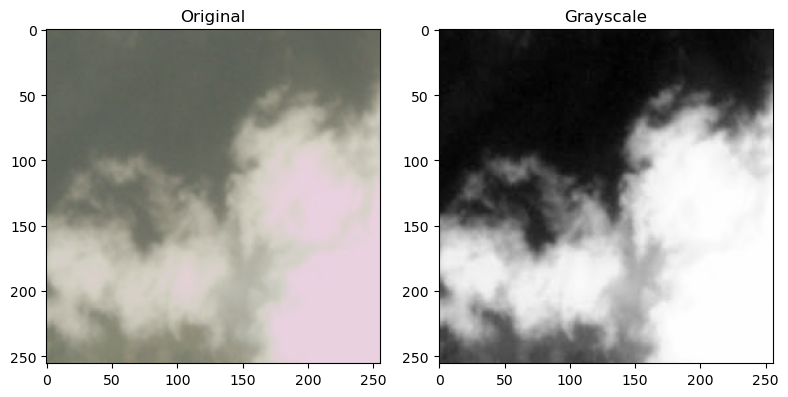

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray
import numpy as np
from sklearn.decomposition import PCA

#From Scikit-image documentation:
#to turn image to greyscale needs 3 channel rgb representation normal jpg doesn't work, need to make sure it comes as RGB
img1 = Image.open('data/cloudy/train_12.jpg').convert("RGB")
img2 = Image.open('data/desert/desert(1).jpg').convert("RGB")
img3 = Image.open('data/green_area/Forest_2.jpg').convert("RGB")
img4 = Image.open('data/water/SeaLake_1.jpg').convert("RGB")

#turning images into numpy array (like with skimage.data.astronaut())

img1 = np.array(img1)
img2 = np.array(img2)
img3 = np.array(img3)
img4 = np.array(img4)

grscale1 = rgb2gray(img1)
grscale2 = rgb2gray(img2)
grscale3 = rgb2gray(img3)
grscale4 = rgb2gray(img4)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(img1)
ax[0].set_title("Original")
ax[1].imshow(grscale1, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()



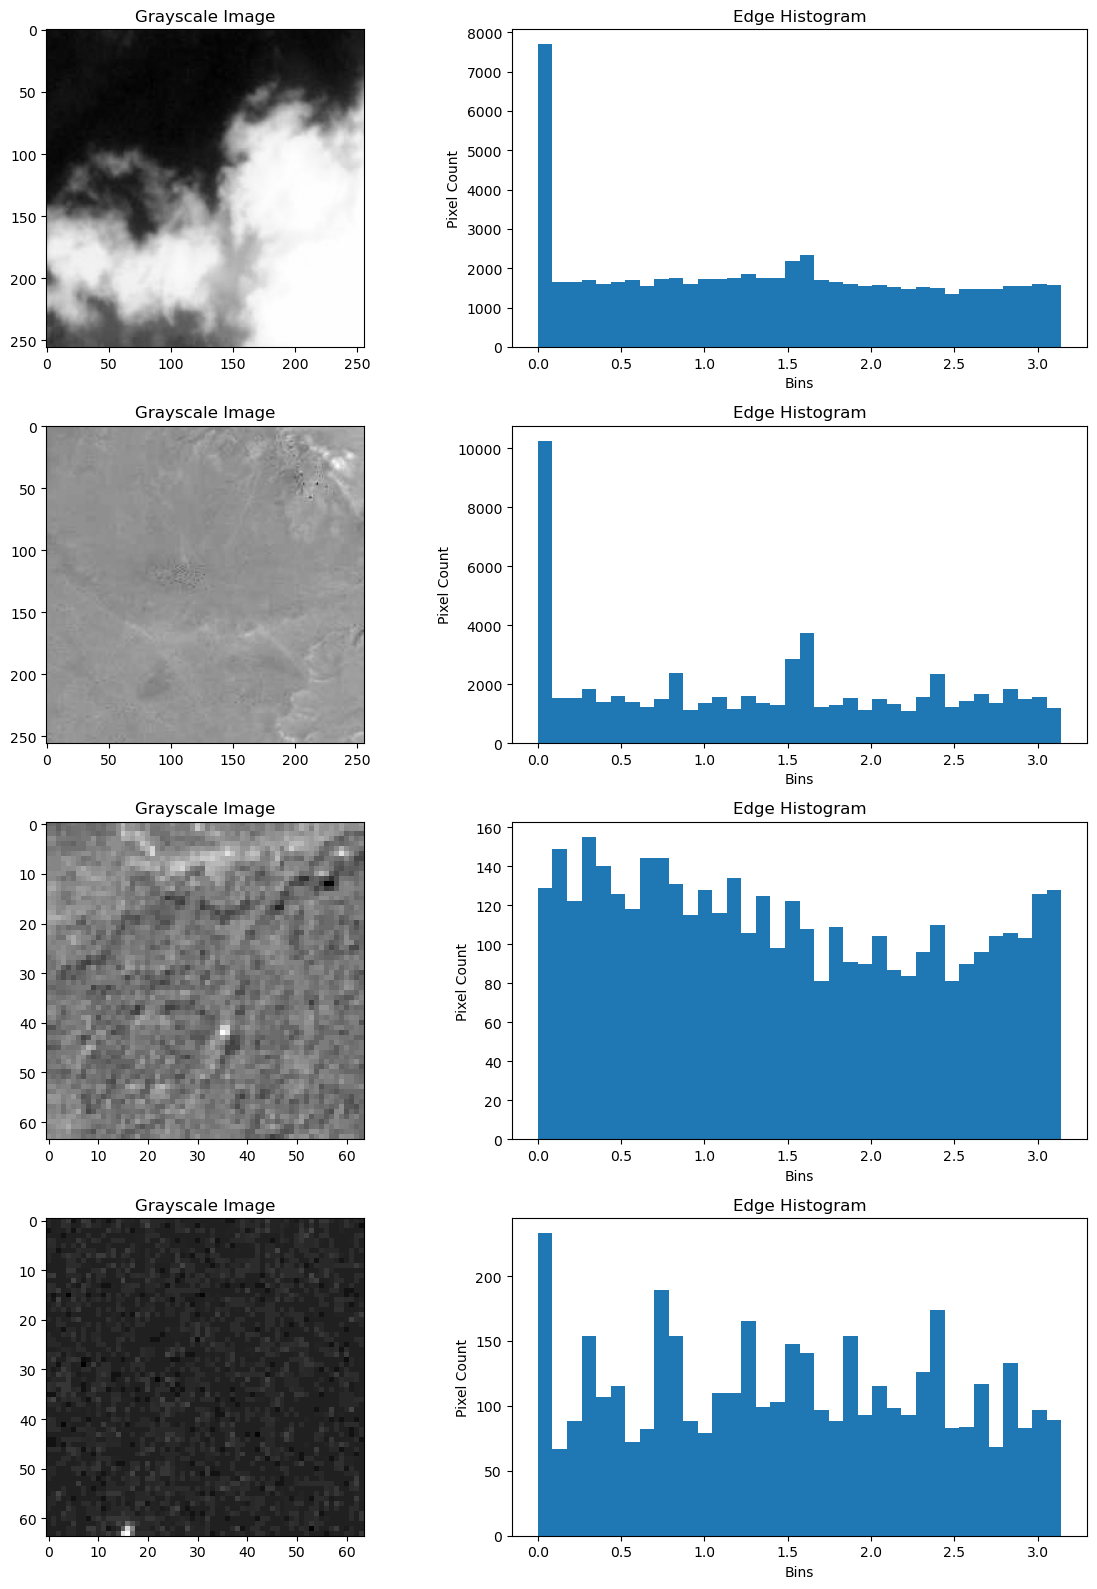

In [25]:
import skimage
from skimage import filters
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)
angle_sobel1 = angle(filters.sobel_h(grscale1), filters.sobel_v(grscale1))
angle_sobel2 = angle(filters.sobel_h(grscale2), filters.sobel_v(grscale2))
angle_sobel3 = angle(filters.sobel_h(grscale3), filters.sobel_v(grscale3))
angle_sobel4 = angle(filters.sobel_h(grscale4), filters.sobel_v(grscale4))

pairs = [(grscale1, angle_sobel1), (grscale2, angle_sobel2), (grscale3, angle_sobel3), (grscale4, angle_sobel4)]


fig, axes = plt.subplots(4, 2, figsize=(12, 16))
hist1 = 0
hist2 = 0

for i, (image, angle_sobel) in enumerate(pairs):
    hist, bin_centers = skimage.exposure.histogram(angle_sobel, nbins = 36)
    if i == 0:
        hist1 = hist
    if i == 1:
        hist2 = hist
    
    axes[i, 0].imshow(image, cmap="gray")
    axes[i, 0].set_title("Grayscale Image")
    
    axes[i, 1].bar(bin_centers, hist, width=np.pi/36)
    axes[i, 1].set_title("Edge Histogram")
    axes[i, 1].set_xlabel("Bins")
    axes[i, 1].set_ylabel("Pixel Count")

plt.tight_layout()
plt.show()

In [34]:
#2f going to use histograms for images 1 and 2
import sklearn
hist1 = hist1.reshape(1, -1)
hist2 = hist2.reshape(1, -1)
euclid = sklearn.metrics.pairwise.euclidean_distances(hist1, hist2)
manhattan = sklearn.metrics.pairwise.manhattan_distances(hist1, hist2)
cosine = sklearn.metrics.pairwise.cosine_distances(hist1, hist2)
print(euclid)
print(manhattan)
print(cosine)

[[3553.38627228]]
[[13528.]]
[[0.02719735]]


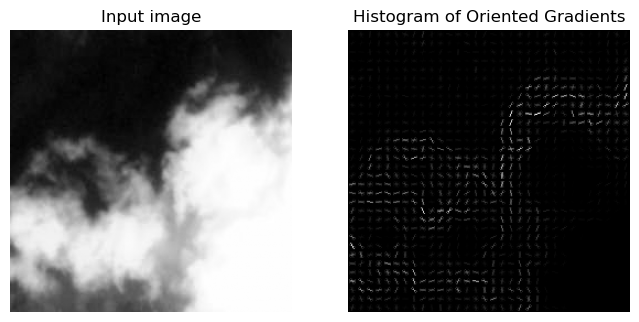

[0.17550435 0.036172   0.02229237 ... 0.         0.         0.        ]


In [42]:
#3a going to use image 1 (seems like it will have a good representation for HOG)
from skimage.feature import hog
from skimage import exposure
image = grscale1

fd, hog_image = hog(
    image,
    orientations=8,
    #was playing around with different values below are those used in example link
    #but because the params are optional i felt as though the default output was 
    #more concise and limiting pixels and cells made the output a bit "muddy"
    #pixels_per_cell=(16, 16),
    #cells_per_block=(1, 1),
    visualize=True,
    channel_axis=None,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
print(fd)

In [84]:
#4a/b need to get all images to greyscale and histogram them
import os
import glob

paths = ["data/cloudy", "data/desert", "data/green_area", "data/water"]
histograms = []

labels = []

for path in paths:
    for file in glob.glob(os.path.join(path, "*.jpg")):
        img = Image.open(file).convert("RGB")
        grscale = rgb2gray(img)
        angle_sobel = angle(filters.sobel_h(grscale), filters.sobel_v(grscale))
        hist, bin_centers = exposure.histogram(angle_sobel, nbins=36)
        histograms.append(hist)
        labels.append(path)
        
histograms = np.array(histograms)
labels = np.array(labels)

print(histograms.shape)
print(labels.shape)
        

(5631, 36)
(5631,)


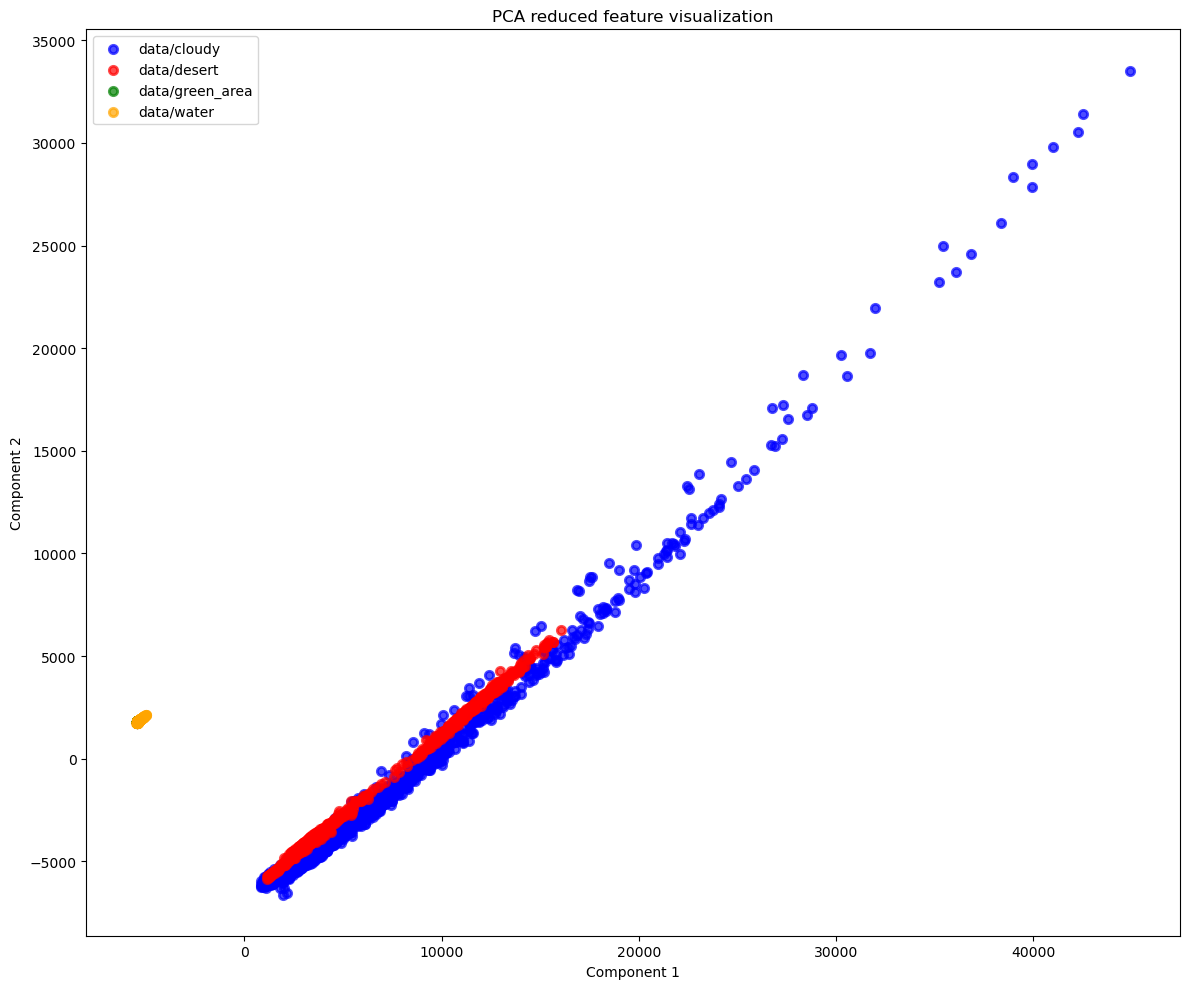

In [95]:
#4c/d PCA Dim reduct
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X = histograms
Y = labels

pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

colors = ["blue", "red", "green", "orange"]
classes = np.unique(Y)

plt.figure(figsize=(12, 10))

for color, target in zip(colors, classes):
    plt.scatter(
        X_reduced[Y == target, 0],  # PC1
        X_reduced[Y == target, 1],  # PC2
        color=color,
        alpha=0.8,
        lw=2,
        label=target,
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA reduced feature visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


From the output plot, the cloudy class is the only one that remotely separates at all, and even the,n it is not fully separated. The majority of the class is grouped with the desert area and following that some of the dataset separates, while everything else groups itself with at least 1 other class with green area and water tightly clumping together.

In [98]:
#5 countvectorizer and tfidfvectorizer
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
countvectorizer = CountVectorizer()
tfidfvectorizer = TfidfVectorizer()

path = "student_4/train.json"
data = []
with open(path, "r") as f:
    for line in f:
        temp = json.loads(line)
        data.append(temp)

df = pd.DataFrame(data)

text = df["Tweet"].tolist()
#df = pd.read_json(path, lines=True)
#print(df.head)
#print(data)

X = countvectorizer.fit_transform(text)
#print(X.toarray()[0])
#countvectorizer.get_feature_names_out()
print("Countvector shape:", X.shape)

X_tfidf = tfidfvectorizer.fit_transform(text)
print("TFIDF shape:", X_tfidf.shape)

Countvector shape: (3000, 9667)
TFIDF shape: (3000, 9667)


Dimensionality of the vector representations is 3000 by 9667, meaning there are 3000 tweets in the training set and 9667 unique text features

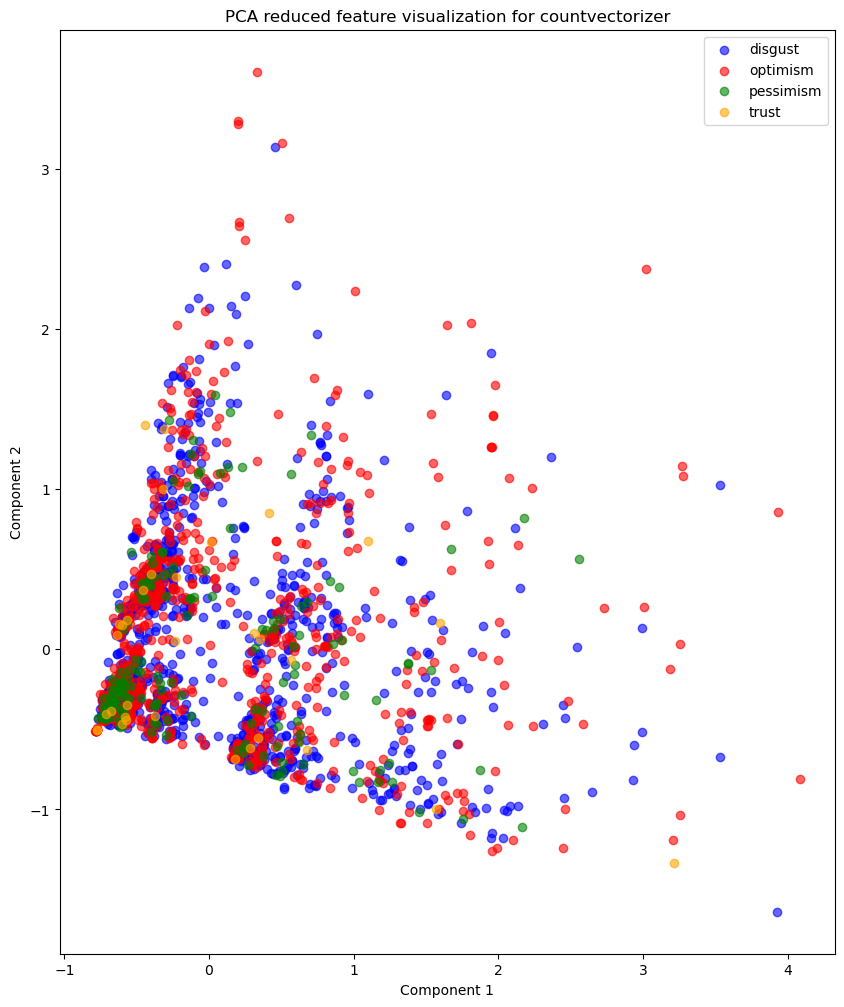

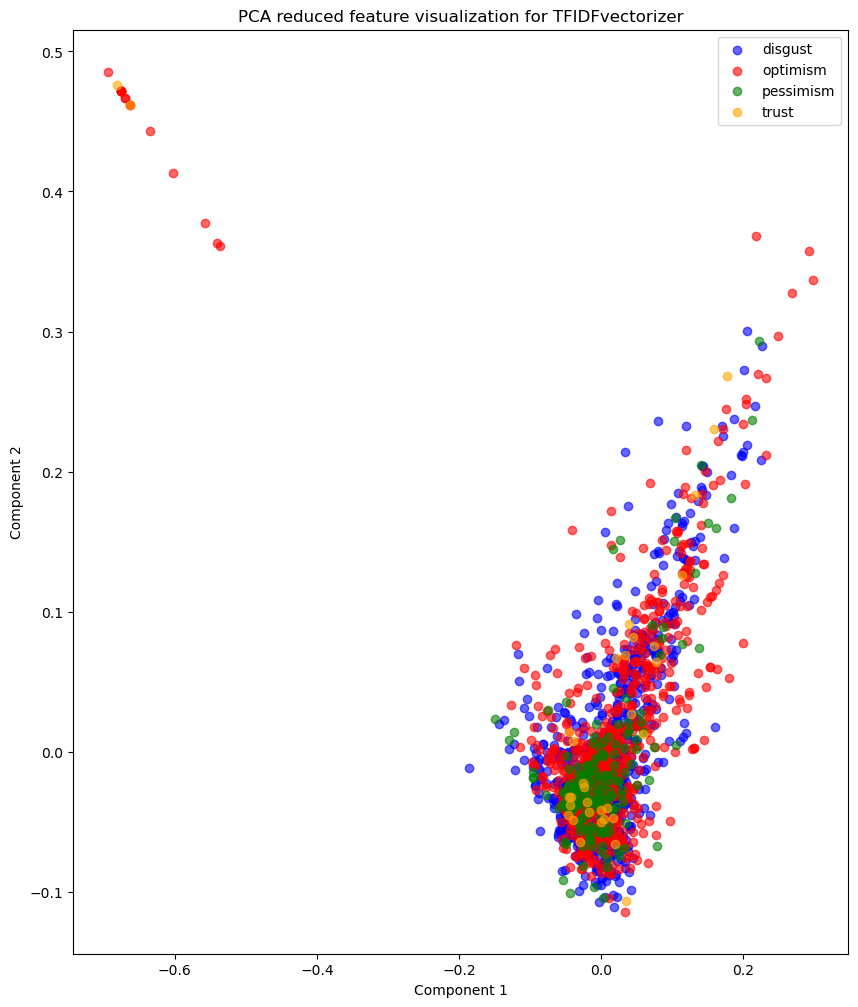

In [100]:
#5 (cont.) dim reduction and plotting of 4 classes

classes = ["disgust", "optimism", "pessimism", "trust"]

filter = df[classes].any(axis=1).to_numpy()
df2 = df[filter].copy()

df2["label"] = df2[classes].idxmax(axis=1)

X_new = X[filter]
X_tfidf_new = X_tfidf[filter]
Y_new = df2["label"].values

PCA_new = PCA(n_components=2)
X_new = PCA_new.fit_transform(X_new.toarray())

PCA_tfidf = PCA(n_components=2)
X_tfidf_new = PCA_tfidf.fit_transform(X_tfidf_new.toarray())

plt.figure(figsize=(10,12))
for color, target in zip(colors, classes):
    filt = (Y_new == target)
    plt.scatter(X_new[filt,0], X_new[filt,1], color=color, alpha=0.6, label=target)
plt.title("PCA reduced feature visualization for countvectorizer")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

plt.figure(figsize=(10,12))
for color, target in zip(colors, classes):
    filt = (Y_new == target)
    plt.scatter(X_tfidf_new[filt,0], X_tfidf_new[filt,1], color=color, alpha=0.6, label=target)
plt.title("PCA reduced feature visualization for TFIDFvectorizer")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

From what I can see, there is no real place where any of my selected tags discern themselves from one another, for both of the plots. I have a feeling this could be because the idxmax step is potentially only recording the first instance of a value being true across the entry, but I am not 100% certain if that would impact the chart in such a way to separate them entirely